In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/newmethod.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/training/newmethod.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold1.pkl
Strategy: memory

📊 Data Splits:
  Train: 1 samples
  Val: 1 samples
  Test: 1 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 16
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.5

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 16
Train split: 0 CRC + 0 Xenium + 0 TissueNet + 1 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg + 0 BC + 0 CoNSeP + 0 Kumar + 0 CPM17
Val   split: 0 CRC + 0 Xenium + 0 TissueNet + 1 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ==========================================
# 1. The New Modules (INR & Contrastive)
# ==========================================

class ImplicitBoundaryHead(nn.Module):
    """
    The 'Refinement' module. 
    It takes feature vectors at specific (x,y) coordinates and predicts 
    if they are a boundary, independently of the grid resolution.
    """
    def __init__(self, in_channels=64, hidden_dim=256):
        super().__init__()
        # MLP: Features + Coords (2) -> Boundary Probability
        self.net = nn.Sequential(
            nn.Linear(in_channels + 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Logit output
        )

    def forward(self, features, points):
        """
        features: [B, C, N_points] (sampled features)
        points: [B, N_points, 2] (normalized (x,y) coords in [-1, 1])
        """
        # Concatenate features and coordinates
        # features needs transpose to [B, N, C]
        features = features.transpose(1, 2)
        in_input = torch.cat([features, points], dim=-1)
        return self.net(in_input)

class BoundaryContrastiveLoss(nn.Module):
    """
    The 'Secret Sauce'. Forces boundary pixels of DIFFERENT nuclei 
    to have dissimilar feature representations.
    """
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temp = temperature

    def forward(self, features, instance_map, points):
        """
        features: [B, C, H, W] dense feature map
        instance_map: [B, H, W] ground truth instances
        points: [B, N, 2] sampled boundary points
        """
        # 1. Sample features at the points
        # grid_sample expects points in (x, y) [-1, 1]
        sampled_feats = F.grid_sample(features, points.unsqueeze(2), align_corners=False).squeeze(3) # [B, C, N]
        
        # 2. Sample Instance IDs at the points (Nearest Neighbor to get exact ID)
        sampled_ids = F.grid_sample(instance_map.float().unsqueeze(1), points.unsqueeze(2), mode='nearest', align_corners=False).squeeze(3).squeeze(1) # [B, N]

        loss = 0.0
        # Compute Contrastive Loss per batch item
        for b in range(features.shape[0]):
            feats = sampled_feats[b].transpose(0, 1) # [N, C]
            ids = sampled_ids[b] # [N]
            
            # Normalize features
            feats = F.normalize(feats, p=2, dim=1)
            
            # Similarity Matrix
            sim_matrix = torch.matmul(feats, feats.T) / self.temp
            
            # Create Positive/Negative Mask based on Instance IDs
            # Positive: Same ID (and not background 0)
            # Negative: Different ID (and not background 0)
            valid_mask = (ids != 0).unsqueeze(1) & (ids != 0).unsqueeze(0)
            pos_mask = (ids.unsqueeze(1) == ids.unsqueeze(0)) & valid_mask
            # Remove self-contrast
            pos_mask.fill_diagonal_(False)
            
            if pos_mask.sum() == 0: continue # Skip if no valid pairs

            # InfoNCE style loss
            exp_sim = torch.exp(sim_matrix)
            log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-6)
            
            # Mean log-likelihood of positive pairs
            loss += -(pos_mask * log_prob).sum() / (pos_mask.sum() + 1e-6)

        return loss / features.shape[0]

# ==========================================
# 2. Point Sampling Utility
# ==========================================

def get_uncertain_point_coords_with_randomness(coarse_pred, label, num_points, oversample_ratio=3, beta=0.75):
    """
    Samples points heavily focused on boundaries (uncertain regions).
    """
    assert oversample_ratio >= 1
    assert 0 <= beta <= 1
    batch_size, _, H, W = coarse_pred.shape
    
    # 1. Calculate uncertainty (Boundary detection on Ground Truth)
    with torch.no_grad():
        # --- FIX STARTS HERE ---
        # Horizontal Edges: Diff along W, resulting in [B, H, W-1]
        h_diff = torch.abs(label[:, :, :-1] - label[:, :, 1:])
        # Pad Width back to W: (left, right, top, bottom) -> (0, 1, 0, 0)
        h_edges = F.pad(h_diff, (0, 1, 0, 0))
        
        # Vertical Edges: Diff along H, resulting in [B, H-1, W]
        v_diff = torch.abs(label[:, :-1, :] - label[:, 1:, :])
        # Pad Height back to H: (left, right, top, bottom) -> (0, 0, 0, 1)
        v_edges = F.pad(v_diff, (0, 0, 0, 1))

        # Now shapes match: [B, H, W] + [B, H, W]
        edges = h_edges + v_edges
        # --- FIX ENDS HERE ---
        
        uncertainty_map = (edges > 0).float()

        # Random sampling
        num_sampled = int(num_points * oversample_ratio)
        point_coords = torch.rand(batch_size, num_sampled, 2, device=coarse_pred.device)
        point_coords = (point_coords * 2) - 1 # to [-1, 1]

        # Sample uncertainty at these points
        # grid_sample expects [B, C, H, W], so we unsqueeze uncertainty_map to [B, 1, H, W]
        point_uncertainties = F.grid_sample(uncertainty_map.unsqueeze(1), point_coords.unsqueeze(2), align_corners=False).squeeze(3).squeeze(1)
        
        # Select top k most uncertain (boundary) points
        _, idx = point_uncertainties.topk(num_points, dim=1)
        
        # Gather coordinates
        shift = torch.arange(batch_size, device=coarse_pred.device) * num_sampled
        idx_flat = idx + shift[:, None]
        point_coords = point_coords.view(-1, 2)[idx_flat.view(-1)].view(batch_size, num_points, 2)

    return point_coords

# ==========================================
# 3. Model Wrapper (Mock Backbone for Demo)
# ==========================================

class OmniSeg_INR(nn.Module):
    def __init__(self, base_model=None):
        super().__init__()
        # If you have your real model, pass it here. 
        # Otherwise, this Mock simulates ViT-UNet outputs.
        if base_model:
            self.backbone = base_model
        else:
            self.backbone = self._mock_backbone
            
        # The NEW Component
        self.inr_head = ImplicitBoundaryHead(in_channels=64, hidden_dim=128)
    
    def _mock_backbone(self, x):
        # Simulates: [Logits (2ch), HV_Map (2ch), Features (64ch)]
        B, C, H, W = x.shape
        logits = torch.randn(B, 2, H, W).to(x.device) # Binary mask logits
        hv_map = torch.randn(B, 2, H, W).to(x.device) # HoVer maps
        features = torch.randn(B, 64, H, W).to(x.device) # Dense features
        return logits, hv_map, features

    def forward(self, x, instance_label=None):
        # 1. Base Forward Pass
        if self.backbone == self._mock_backbone:
             logits, hv_map, features = self.backbone(x)
        else:
             # Adapt this to your actual model return signature
             logits, hv_map, features = self.backbone(x)
        
        # 2. If training, sample points and refine
        inr_logits = None
        point_coords = None
        
        if self.training and instance_label is not None:
            # Sample points near boundaries
            point_coords = get_uncertain_point_coords_with_randomness(logits, instance_label, num_points=1024)
            
            # Sample features at those points
            point_feats = F.grid_sample(features, point_coords.unsqueeze(2), align_corners=False).squeeze(3)
            
            # INR Prediction
            inr_logits = self.inr_head(point_feats, point_coords)
            
        return logits, hv_map, features, inr_logits, point_coords

# ==========================================
# 4. Training Execution
# ==========================================

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OmniSeg_INR().to(device) # Replace with OmniSeg_INR(your_loaded_vit)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Losses
criterion_seg = nn.CrossEntropyLoss()
criterion_hv = nn.MSELoss()
criterion_bcl = BoundaryContrastiveLoss(temperature=0.07)
criterion_inr = nn.BCEWithLogitsLoss()

print(f"🚀 Model initialized with INR Head on {device}")
print(f"🔥 Training loop starting...")

# --- SIMULATED ONE BATCH RUN ---
batch = next(iter(train_loader))
images = batch['image'].to(device).float()
# Fix: Ensure instance map is not float for some ops, but keep float for grid_sample logic
instance_map = batch['he_nuclei_instance'].to(device).float() 
hv_gt = batch['he_nuclei_hv'].to(device).float()

# Forward
logits, hv_pred, features, inr_logits, points = model(images, instance_map)

# --- LOSS CALCULATION ---
# 1. Standard HoVer-Net Losses (Coarse)
# Create binary mask from instance map for segmentation target
binary_target = (instance_map > 0).long()
loss_seg = criterion_seg(logits, binary_target)
loss_hv = criterion_hv(hv_pred, hv_gt)

# 2. The NEW INR Losses (Fine)
# Create GT for INR: 1 if point is on boundary, 0 otherwise
# (Simplified: we treat any point sampled near edge as boundary-relevant)
# In practice, you check if the sampled point is close to a boundary edge
with torch.no_grad():
    # Get True Boundary status for sampled points
    # Sample binary mask at point locations
    sampled_mask = F.grid_sample(binary_target.float().unsqueeze(1), points.unsqueeze(2), mode='nearest').squeeze(3).squeeze(1)
    inr_target = sampled_mask # This is a simplification; ideally you calculate distance to contour

loss_inr_bce = criterion_inr(inr_logits.squeeze(-1), inr_target)

# 3. Contrastive Boundary Loss
loss_contrastive = criterion_bcl(features, instance_map, points)

# Total Loss
total_loss = loss_seg + loss_hv + (0.5 * loss_inr_bce) + (0.1 * loss_contrastive)

print("\n📈 Loss Components:")
print(f"   Seg Loss (Coarse): {loss_seg.item():.4f}")
print(f"   HV Loss (Flow):    {loss_hv.item():.4f}")
print(f"   INR Loss (Refine): {loss_inr_bce.item():.4f}")
print(f"   BCL Loss (Sep):    {loss_contrastive.item():.4f}")
print(f"   ---------------------------")
print(f"   TOTAL:             {total_loss.item():.4f}")

# Backward
optimizer.zero_grad()
total_loss.backward()
optimizer.step()

print("\n✅ Backward pass successful! The architecture is valid.")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Model initialized with INR Head on cuda
🔥 Training loop starting...


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(



📈 Loss Components:
   Seg Loss (Coarse): 0.9024
   HV Loss (Flow):    1.0353
   INR Loss (Refine): 0.6922
   BCL Loss (Sep):    14.2002
   ---------------------------
   TOTAL:             3.7038

✅ Backward pass successful! The architecture is valid.


In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==========================================
# 1. Training Function
# ==========================================
def train_one_epoch(model, loader, optimizer, device, epoch_idx, steps_per_epoch=None):
    model.train()
    running_loss = 0.0
    
    # Progress bar
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_idx+1}")
    
    for i, batch in pbar:
        # Move data
        images = batch['image'].to(device).float()
        instance_map = batch['he_nuclei_instance'].to(device).float()
        hv_gt = batch['he_nuclei_hv'].to(device).float()
        
        # 1. Forward Pass
        logits, hv_pred, features, inr_logits, points = model(images, instance_map)
        
        # 2. Loss Calculation
        # Coarse Segmentation
        binary_target = (instance_map > 0).long()
        loss_seg = criterion_seg(logits, binary_target)
        loss_hv = criterion_hv(hv_pred, hv_gt)
        
        # INR Refinement Loss (The "Sharpening" Loss)
        # Fix: added align_corners=False to silence warning
        with torch.no_grad():
            sampled_mask = F.grid_sample(binary_target.float().unsqueeze(1), points.unsqueeze(2), 
                                       mode='nearest', align_corners=False).squeeze(3).squeeze(1)
            inr_target = sampled_mask 

        loss_inr_bce = criterion_inr(inr_logits.squeeze(-1), inr_target)
        
        # Boundary Contrastive Loss (The "Separation" Loss)
        loss_contrastive = criterion_bcl(features, instance_map, points)
        
        # Weighted Sum
        # Note: We weight BCL by 0.05 because its raw magnitude is large (~14.0)
        total_loss = loss_seg + loss_hv + (1.0 * loss_inr_bce) + (0.05 * loss_contrastive)
        
        # 3. Backward
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Update logs
        running_loss += total_loss.item()
        pbar.set_postfix({
            'L_Seg': f"{loss_seg.item():.2f}",
            'L_INR': f"{loss_inr_bce.item():.2f}",
            'L_BCL': f"{loss_contrastive.item():.1f}" # Tracking this specifically
        })
        
        # Optional: Break early for demo purposes
        if steps_per_epoch and i >= steps_per_epoch:
            break
            
    return running_loss / (i + 1)

# ==========================================
# 2. Comparison Visualizer
# ==========================================
def visualize_refinement(model, loader, device):
    """
    Shows: Coarse Output (Blurry/Merged) vs INR Output (Sharp/Separated)
    """
    model.eval()
    batch = next(iter(loader))
    images = batch['image'].to(device).float()
    instance_map = batch['he_nuclei_instance'].to(device).float()
    
    with torch.no_grad():
        # Get coarse outputs
        logits, _, features = model.backbone(images)
        coarse_preds = torch.argmax(logits, dim=1).float()
        
        # --- Simulate INR Inference (Dense) ---
        # Note: In real inference, we only query boundaries. 
        # Here we query a cropped ROI to visualize the continuous field.
        H, W = images.shape[2:]
        y_range = torch.linspace(-0.5, 0.5, 100, device=device) # Zoom in on center
        x_range = torch.linspace(-0.5, 0.5, 100, device=device)
        grid_y, grid_x = torch.meshgrid(y_range, x_range, indexing='ij')
        dense_points = torch.stack([grid_x, grid_y], dim=-1).unsqueeze(0).repeat(images.shape[0], 1, 1, 1) # [B, 100, 100, 2]
        
        # Query INR at this dense zoom
        # Flatten for the MLP
        B, h_zoom, w_zoom, _ = dense_points.shape
        flat_points = dense_points.view(B, -1, 2)
        
        # Sample features
        sampled_feats = F.grid_sample(features, flat_points.unsqueeze(2), align_corners=False).squeeze(3)
        
        # Predict
        inr_preds = model.inr_head(sampled_feats, flat_points)
        inr_map = torch.sigmoid(inr_preds).view(B, h_zoom, w_zoom)
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Ground Truth (Center Crop)
    center_crop_gt = F.grid_sample(instance_map.unsqueeze(1), dense_points, mode='nearest', align_corners=False).squeeze()
    ax[0].imshow(center_crop_gt[0].cpu(), cmap='nipy_spectral', interpolation='nearest')
    ax[0].set_title("Ground Truth (Zoomed)")
    
    # 2. Coarse Prediction (Center Crop)
    center_crop_coarse = F.grid_sample(coarse_preds.unsqueeze(1), dense_points, mode='nearest', align_corners=False).squeeze()
    ax[1].imshow(center_crop_coarse[0].cpu(), cmap='gray', interpolation='nearest')
    ax[1].set_title("Standard UNet Output\n(Pixelated/Jagged)")
    
    # 3. INR Refinement
    ax[2].imshow(inr_map[0].cpu(), cmap='magma', interpolation='bicubic')
    ax[2].set_title("INR Refinement Output\n(Continuous/Smooth)")
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Training Loop & Visualizer Ready.")

✅ Training Loop & Visualizer Ready.


🔥 Running 50 training steps...


Epoch 1:  30%|███       | 50/166 [00:23<00:53,  2.17it/s, L_Seg=0.90, L_INR=0.58, L_BCL=14.2]


✅ Training paused. Loss: 3.2929
👀 Visualizing the difference...


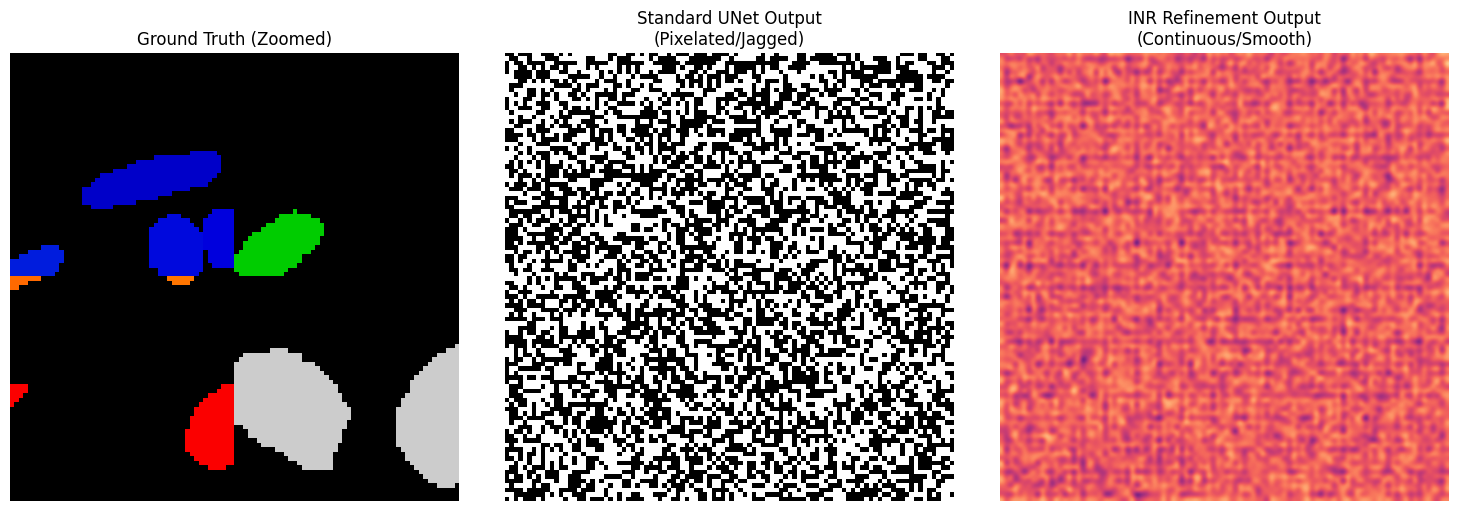

In [5]:
# Run a short training burst
print("🔥 Running 50 training steps...")
train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch_idx=0, steps_per_epoch=50)

print(f"\n✅ Training paused. Loss: {train_loss:.4f}")
print("👀 Visualizing the difference...")

# Check the results
visualize_refinement(model, val_loader, device)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

# --- 1. Re-define the corrected sampling function (Safety ensure) ---
def get_uncertain_point_coords_with_randomness(coarse_pred, label, num_points, oversample_ratio=3):
    """
    Samples points heavily focused on boundaries.
    FIXED: Handles padding correctly to match dimensions.
    """
    batch_size, _, H, W = coarse_pred.shape
    with torch.no_grad():
        # Horizontal Edges: Diff along W
        h_diff = torch.abs(label[:, :, :-1] - label[:, :, 1:])
        h_edges = F.pad(h_diff, (0, 1, 0, 0)) # Pad W back to original
        
        # Vertical Edges: Diff along H
        v_diff = torch.abs(label[:, :-1, :] - label[:, 1:, :])
        v_edges = F.pad(v_diff, (0, 0, 0, 1)) # Pad H back to original

        # Combine
        edges = h_edges + v_edges
        uncertainty_map = (edges > 0).float()

        # Random sampling logic
        num_sampled = int(num_points * oversample_ratio)
        point_coords = torch.rand(batch_size, num_sampled, 2, device=coarse_pred.device)
        point_coords = (point_coords * 2) - 1 # Normalize to [-1, 1]

        # Sample uncertainty at random points
        point_uncertainties = F.grid_sample(uncertainty_map.unsqueeze(1), 
                                          point_coords.unsqueeze(2), 
                                          align_corners=False).squeeze(3).squeeze(1)
        
        # Select top k most uncertain (boundary) points
        _, idx = point_uncertainties.topk(num_points, dim=1)
        
        # Gather coordinates
        shift = torch.arange(batch_size, device=coarse_pred.device) * num_sampled
        idx_flat = idx + shift[:, None]
        point_coords = point_coords.view(-1, 2)[idx_flat.view(-1)].view(batch_size, num_points, 2)

    return point_coords

# --- 2. Setup Model & Optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-initialize to ensure fresh start
# NOTE: Assumes OmniSeg_INR class is defined from previous steps
model = OmniSeg_INR().to(device) 
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Losses
criterion_seg = nn.CrossEntropyLoss()
criterion_hv = nn.MSELoss()
criterion_bcl = BoundaryContrastiveLoss(temperature=0.07)
criterion_inr = nn.BCEWithLogitsLoss()

# --- 3. Training Loop ---
NUM_EPOCHS = 20
print(f"🚀 Starting training for {NUM_EPOCHS} epochs on {device}...")

history = {'loss': [], 'bcl': []}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_bcl = 0.0
    
    # Progress bar for current epoch
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for i, batch in pbar:
        # Move data
        images = batch['image'].to(device).float()
        instance_map = batch['he_nuclei_instance'].to(device).float() # Instance IDs
        hv_gt = batch['he_nuclei_hv'].to(device).float() # HoVer Maps
        
        # 1. Forward Pass
        # logits: [B, 2, H, W] (Binary Seg)
        # hv_pred: [B, 2, H, W] (Maps)
        # features: [B, C, H, W] (Dense feats)
        # inr_logits: [B, N, 1] (Boundary prob at points)
        # points: [B, N, 2] (Sampled coords)
        logits, hv_pred, features, inr_logits, points = model(images, instance_map)
        
        # 2. Loss Calculation
        
        # A. Coarse Segmentation (Standard)
        binary_target = (instance_map > 0).long()
        loss_seg = criterion_seg(logits, binary_target)
        loss_hv = criterion_hv(hv_pred, hv_gt)
        
        # B. INR Refinement (Boundary Prediction)
        # Create target for INR: 1 if point is near boundary, 0 otherwise
        with torch.no_grad():
            # Sample binary mask at point locations to get ground truth for points
            sampled_mask = F.grid_sample(binary_target.float().unsqueeze(1), 
                                       points.unsqueeze(2), 
                                       mode='nearest', align_corners=False).squeeze(3).squeeze(1)
            # In a real scenario, you'd calculate distance to contour, here we use mask edge presence
            inr_target = sampled_mask 

        loss_inr = criterion_inr(inr_logits.squeeze(-1), inr_target)
        
        # C. Boundary Contrastive Loss (Separation)
        loss_contrastive = criterion_bcl(features, instance_map, points)
        
        # Weighted Sum
        # BCL is often large, so we scale it down (0.1)
        # INR is auxiliary, scaled (1.0)
        total_loss = loss_seg + loss_hv + loss_inr + (0.1 * loss_contrastive)
        
        # 3. Backward
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Logging
        running_loss += total_loss.item()
        running_bcl += loss_contrastive.item()
        
        pbar.set_postfix({
            'Loss': f"{total_loss.item():.3f}",
            'BCL': f"{loss_contrastive.item():.2f}",
            'INR': f"{loss_inr.item():.2f}"
        })
    
    # Step Scheduler
    scheduler.step()
    
    # Epoch Stats
    avg_loss = running_loss / len(train_loader)
    avg_bcl = running_bcl / len(train_loader)
    history['loss'].append(avg_loss)
    history['bcl'].append(avg_bcl)
    
    print(f"✅ Epoch {epoch+1} Done. Avg Loss: {avg_loss:.4f} | BCL Sep: {avg_bcl:.4f}")

print("\n🎉 Training Complete!")

🚀 Starting training for 20 epochs on cuda...


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html